# AST 502: Lecture 10: Parametric Density Estimation
## Ben W.P. Lew, Fall 2017, Chapter 6.3
Parametric vs Non-parametric Density Estimation  
Caveat of using Gaussian Mixture Model(GMM)   
Application of GMM:
Resampling data with distribution
    
Gaussian Mixture Model with errors: Extreme Deconvolution  

Figures in the slides are from Ivezić book with some modfications.

# Parametric Density Estimation vs Non-Parametric Density Estimation
**Non-parametric methods**: kernel function,historgram,deconvolved kernel with noise, nearest-neighbor density estimation, tessellation  
KDE: Each data point becomes probability density distribution with predefined width and unit height.  The kernel can be gaussian, box, exponential, etc.

**Parametric methods**: Use few kernels, and fit for the location and width of kernels $\rightarrow$ mixture model.  
The most common(favorite) mixture: **Gaussian Mixture Model**

# Gaussian Mixture Model  
The density of the points is given by eq (cf eq.4.18)

\begin{equation} \tag{6.17}
\rho ({\bf x}) = Np({\bf x})= N \sum\limits_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \scriptstyle \sum_j) 
\end{equation}
Covariance type: spherical,tied, dioagonal,full  
**Diagonal**   
Gaussians with diagonal covariance matrices.  
**Full**  
Gaussians with full covariance. May overfit for small sample dataset  
**Spherical**  
Spherical Gaussians: variance is the same along all axes and zero across-axes.  
**Tied**  
Gaussians with a tied covariance matrix; the same covariance matrix is shared by all the gaussians.  
<img src="covariancetype.png" alt="Drawing" style="width: 600px " img style="float: right"/>

credit:
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

## How many components are required to fit my data?  


@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  7


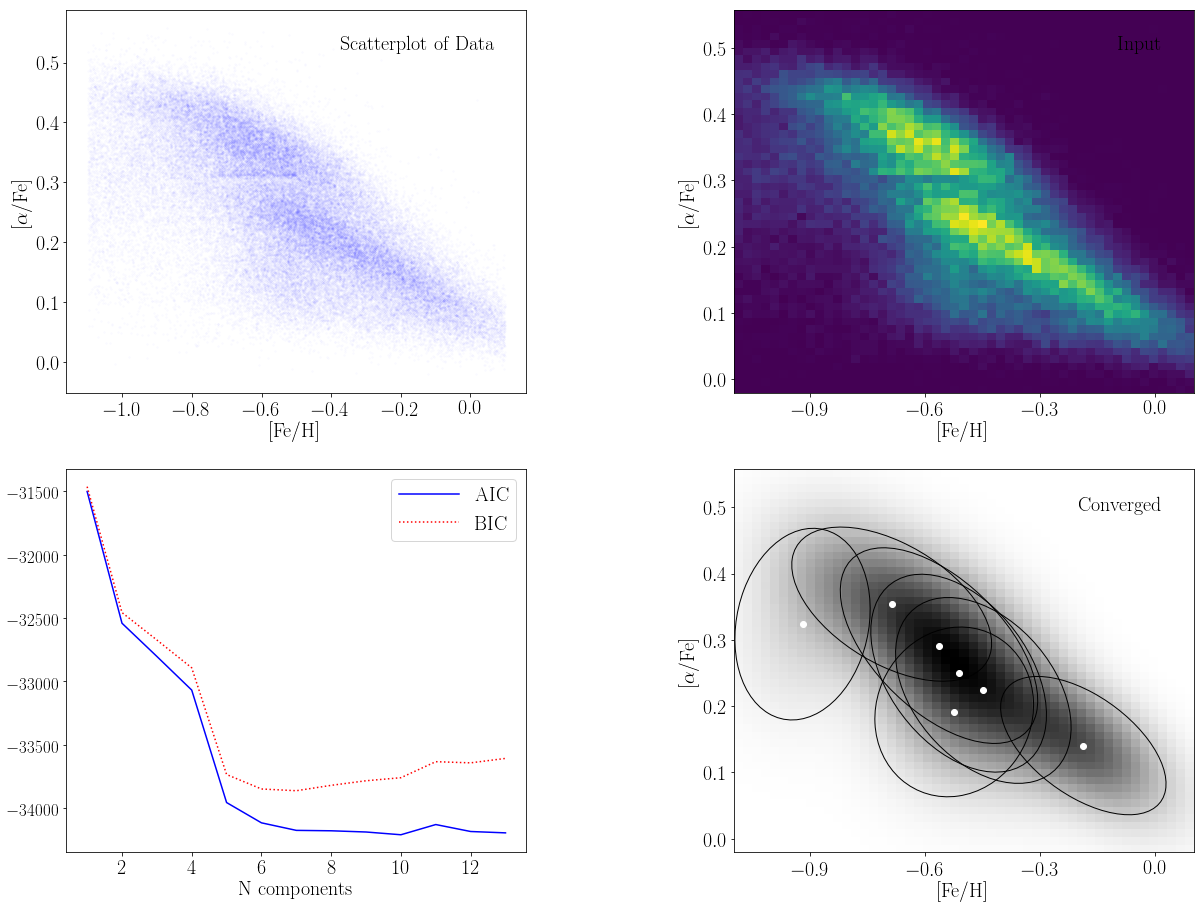

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline
from sklearn.mixture import GMM
import warnings
warnings.filterwarnings('ignore')
from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print N[i]
        models[i] = GMM(n_components=N[i], n_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:])))).T
log_dens = gmm_best.score(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(221)
ax.scatter(data['FeH'], data['alphFe'],alpha=0.01,s=3,color='blue')
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.text(0.93, 0.93, "Scatterplot of Data",
        va='top', ha='right', transform=ax.transAxes)
ax = fig.add_subplot(222)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]])
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(223)
ax.plot(N, AIC, '-b', label='AIC')
ax.plot(N, BIC, ':r', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=17)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(224)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

# How many components are required to fit my data?  

<img src="figure6_6.png" alt="Drawing" style="width: 600px " img style="float: right"/>
*Answer: It depends how well your assumptions to describe the data. BIC/AIC **DOES NOT*** necessarily guarantee there are N true components.

Also, sample size matters...  
<img src="figure6_9.png" alt="Drawing" style="width: 600px " img style="float: right"/>


# Using Gaussian Mixture Model for Density Estimation
1. Resampling high-dimension data distribution  
2. Fitting complete distribution function from heteroscdatic, noisy, incomplete data  

# 1. Resampling high-dimension data distribution
## Resampling 1-dimension data distribution
<img src="fig3.25.png" alt="Drawing" style="width: 600px " img style="float: right"/>




# Resamping 2-dimensional data distribution
GMM fit:
*maximum-likelihood estimation of the parameters of a GMM distribution*

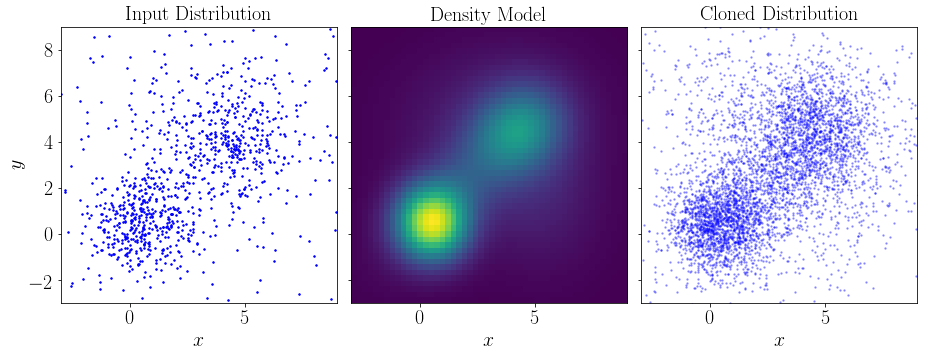

In [8]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.mixture import GMM

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

#------------------------------------------------------------
# Create our data: two overlapping gaussian clumps,
# in a uniform background
np.random.seed(1)
X = np.concatenate([np.random.normal(0, 1, (200, 2)),
                    np.random.normal(1, 1, (200, 2)),
                    np.random.normal(4, 1.5, (400, 2)),
                    9 - 12 * np.random.random((200, 2))])

#------------------------------------------------------------
# Use a GMM to model the density and clone the points
gmm = GMM(5, 'full').fit(X)
X_new = gmm.sample(5000)

xmin = -3
xmax = 9
Xgrid = np.meshgrid(np.linspace(xmin, xmax, 50),
                    np.linspace(xmin, xmax, 50))
Xgrid = np.array(Xgrid).reshape(2, -1).T

dens = np.exp(gmm.score(Xgrid)).reshape((50, 50))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(14, 12))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.05,
                    bottom=0.12, top=0.9)

# first plot the input
ax = fig.add_subplot(131, aspect='equal')
ax.plot(X[:, 0], X[:, 1], '.b', ms=3)

ax.set_title("Input Distribution")
ax.set_ylabel('$y$')

# next plot the gmm fit
ax = fig.add_subplot(132, aspect='equal')
ax.imshow(dens.T, origin='lower', extent=[xmin, xmax, xmin, xmax]
    )

ax.set_title("Density Model")
ax.yaxis.set_major_formatter(plt.NullFormatter())

# next plot the cloned distribution
ax = fig.add_subplot(133, aspect='equal')
ax.plot(X_new[:, 0], X_new[:, 1], '.b', alpha=0.3, ms=3)

ax.set_title("Cloned Distribution")
ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in fig.axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_xlabel('$x$')

plt.show()

...but this assume the data is error-free and complete....

# 2. Fitting complete distribution function from heteroscdatic, noisy, incomplete data  -- Extreme Deconvolution

## Fundamental Expectation-Maximization (EM) Algorithm
(See also Ragadeepika's lecture 1)  
Suppose 
**x**= complete data   
**y** = observed data  
Assume $x \rightarrow y$  
**$\Phi^{(p)}$** =$1\times r$ parameter vector space after p-cycles of the algorithms,   
**t(x)** = $1 \times r$ vector of complete-data sufficient statistics (i.e minimum information to describe random sampling of data under assumed distribution)  
**$f(x|\phi)$**= sampling density , or complete-data-specifications (real data distribution)  
**E-step**: Estimate the complete-data sufficient statistics **t(x)** by finding  
\begin{equation} 
\bf t^{(p)}= E (t(x)|y, \Phi^{(p)})
\end{equation}
example of sufficient statistics: mean and variance for gaussian model  
*--"creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters"*  
**M-step**: Determine $\Phi^{(p+1)}$ as the solution of the equations  
\begin{equation} 
\bf E(t(x)|\Phi)=  t^{(p)}
\end{equation}
*--"computes parameters maximizing the expected log-likelihood found on the E step."*  

*Further reading:*  
"Maximum Likelihood from Incomplete Data via the EM Algorithm (1977)", citation: $>$ 50,000

## Generalized Expectation-Maximization (EM) Algorithm
Derivation of the likelihood of a mixture of Gaussian distribution with missing data and noise:
1. Assume that the observed data is a projection of true value with noise, we want to fit the distribution of true data value:
\begin{equation}
{\bf w_i=R_i v_i + S_i}
\end{equation}
where $w_i$= observational data points; $R_i$= projection matrix; $v_i$=true data value(without noise); $S_i$= noise drawn from Gaussian with zero mean and known covariance.   
2. The probability density of true values as a mixture of K Gaussians:  
\begin{equation}
p(\bf{v})= \sum\limits_{j=1}^{K} \alpha_j \mathcal{N}(v| {\bf m_j, V_j})
\end{equation}
where the amplitudes $\alpha_j$ sum to unity and $\mathcal{N}(v|m,V)$ is Gaussian probability density function with mean **m** and variance matrix **V**
\begin{equation}
\mathcal{N}(\bf{v|m,V})= (2 \pi)^{-d/2} det({\bf V})^{-1/2} exp [ -\frac{1}{2}{\bf (v-m)^{T} V^{-1}(v-m)}]
\end{equation}

2.
The expectation (E) step:

\begin{align*} 
 q_{ij} &\leftarrow \frac{\alpha_j \mathcal{N}({\bf w_i | R_i} \mu_j, {\bf T_{ij}})}
    {\sum_j \alpha_k \mathcal{N}({\bf w_i | R_i} \mu_k, {\bf T_{ij}})} \tag{6.21} \\    
 {\bf b_{ij}} &\leftarrow \mu_j + {\bf {\scriptstyle \sum_{j}} R^T_i T^{-1}_{ij} }({\bf w_i -R_i} \mu_j), \rightarrow \text{(conditional distribution)} \tag{6.22}\\
 {\bf B_{ij}} &\leftarrow  {\bf {\scriptstyle \sum_{j}} -  {\scriptstyle \sum_{j}} R^T_i T^{-1}_{ij} R_i \scriptstyle \sum_j} \tag{6.23}
\end{align*}
where $T_{ij}= R_i {\scriptstyle \sum_j} R^T_i +S_i$

The maximization (M) step:
\begin{align*}
\alpha_i & \leftarrow \frac{1}{N} \sum_i q_{ij}  \tag{6.24}\\
\mu_j & \leftarrow \frac{1}{q_j} \sum_i q_{ij} {\bf b_{ij}} ,\tag{6.25}\\
{\bf \scriptstyle\sum_j }& \leftarrow \frac{1}{q_j} [(\mu_j - {\bf b_{ij}})(\mu_j- {\bf b_{ij}}^T) + {\bf B_{ij}}], \tag{6.26}
\end{align*}

where $q_j = \sum_i q_{ij}$

*Further reading:*  

For the convergence, global minima algorithm(split and merge) for Generalized EM algorithm, see "Extreme Deconvolution: Inferring Complete Dsitribution From Noisy, Heterogeneous And Incomplete Observations" by Bovy et. al 2011.  
For detailed derivation of conditional distribution, see http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html  and https://onlinecourses.science.psu.edu/stat505/node/43  
For detail derivation of maximization step, see examples in "Expectation–maximization algorithm" on Wikipedia.  

@pickle_results: using precomputed results from 'XD_toy.pkl'


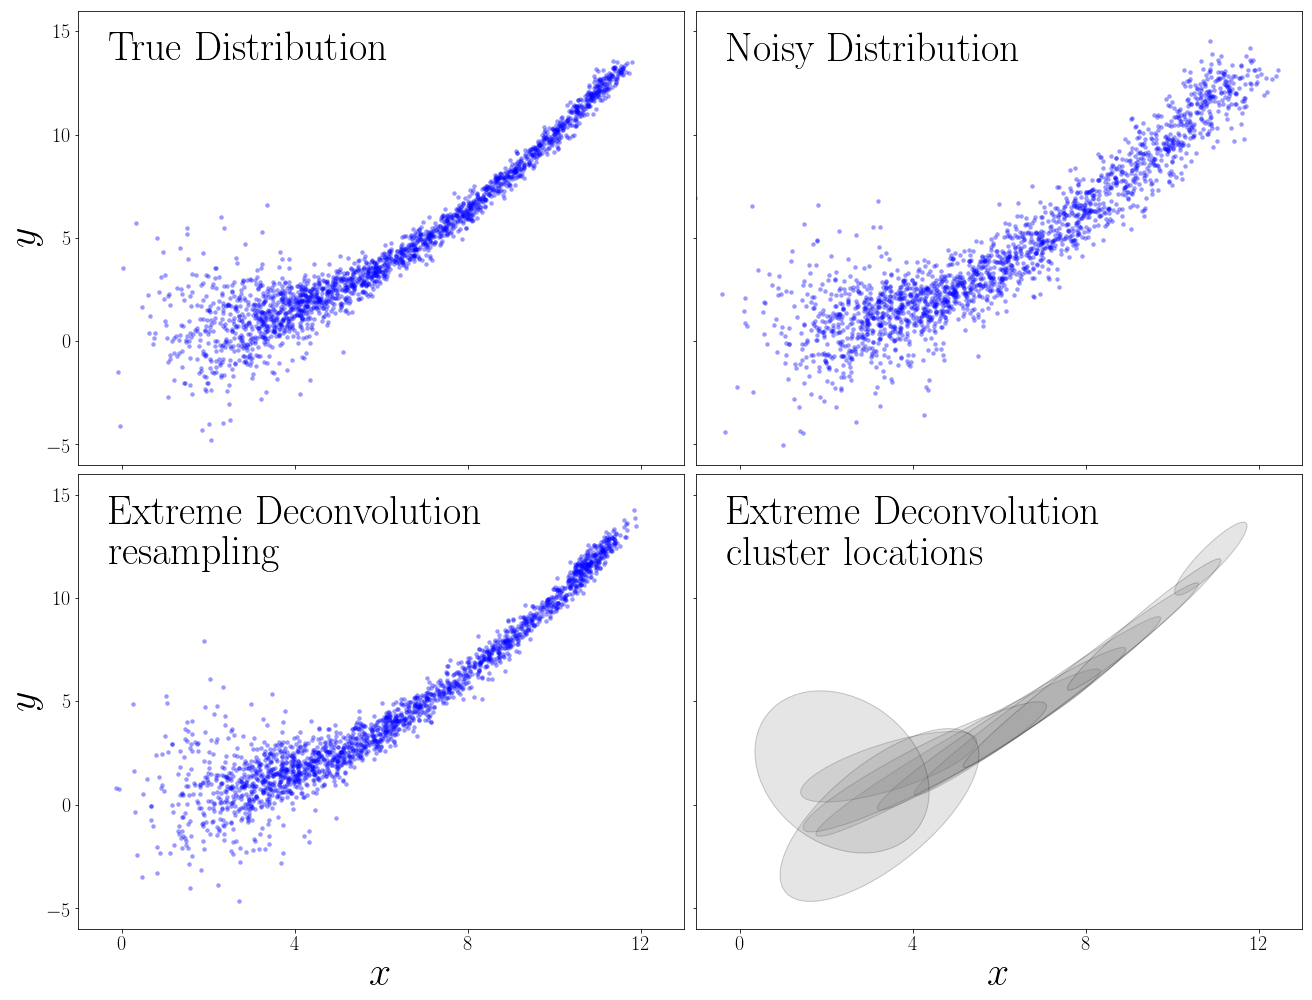

In [48]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astroML.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

#------------------------------------------------------------
# Sample the dataset
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T


#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components=10, n_iter=500):
    clf = XDGMM(n_components, n_iter=n_iter)
    clf.fit(X, Xerr)
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(N)
myfontsize=40
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
dotsize=20
ax1.scatter(x_true, y_true, s=dotsize, lw=0, c='blue',alpha=0.4)

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=dotsize, lw=0, c='blue',alpha=0.4)

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=dotsize, lw=0, c='blue',alpha=0.4)

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes,size=myfontsize)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$',size=myfontsize)

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$',size=myfontsize)

plt.show()

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)
@pickle_results: using precomputed results from 'XD_stellar.pkl'


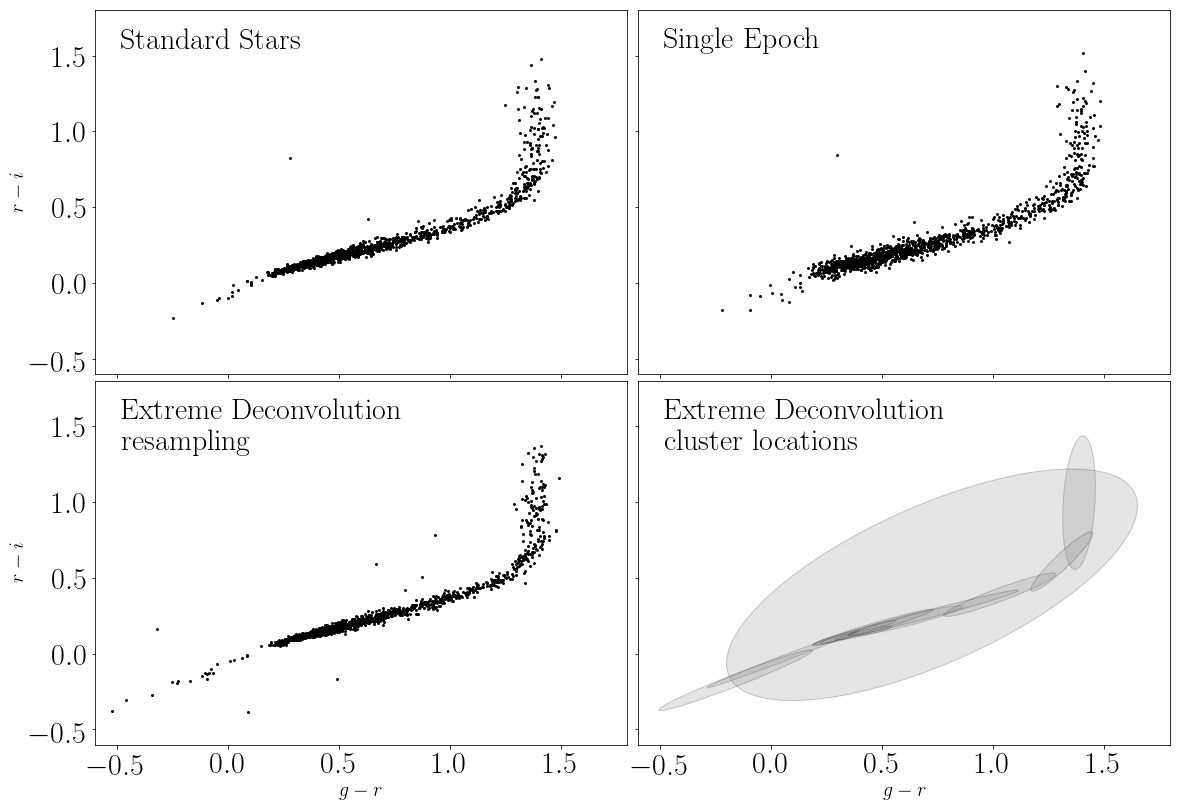

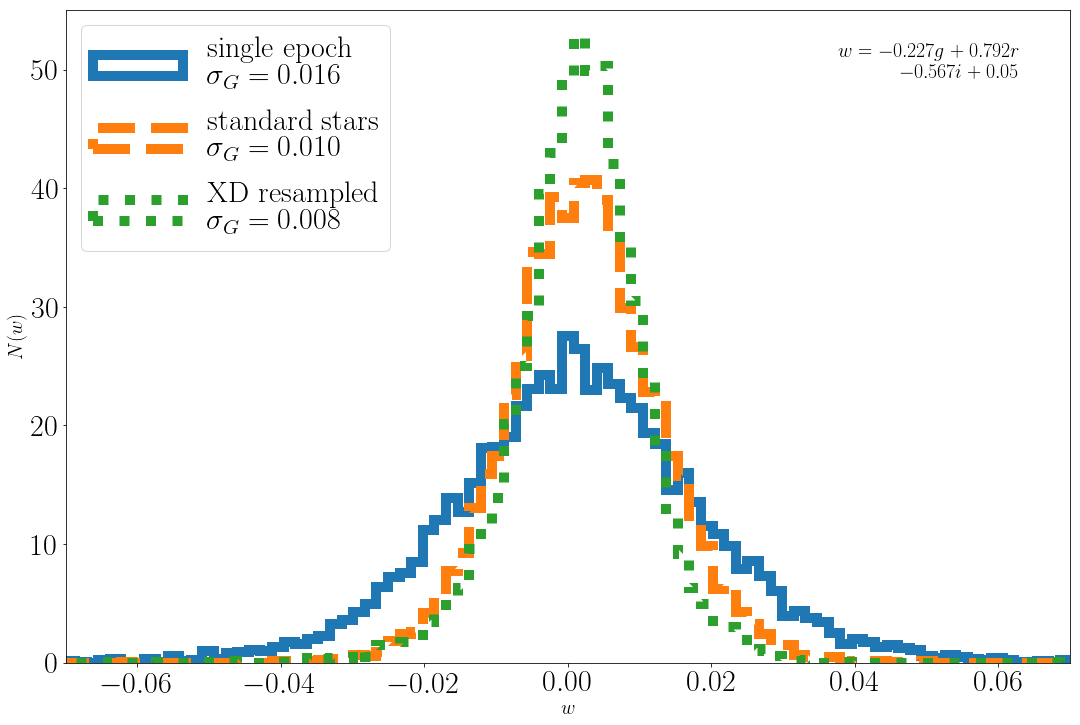

In [7]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.decorators import pickle_results
from astroML.stats import sigmaG

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=30, usetex=True)

#------------------------------------------------------------
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985
# multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

#----------------------------------------------------------------------
# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])


#----------------------------------------------------------------------
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]


#----------------------------------------------------------------------
# cross-match
#  the imaging sample contains both standard and variable stars.  We'll
#  perform a cross-match with the standard star catalog and choose objects
#  which are common to both.
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print "number of noisy points:  ", Xlocs.shape
print "number of stacked points:", Ylocs.shape

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600.)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print "size after crossmatch:", X.shape


#----------------------------------------------------------------------
# perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))


#----------------------------------------------------------------------
# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=12, rseed=0, n_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, n_iter=n_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(18, 12))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$',fontsize=20)

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$',fontsize=20)

#------------------------------------------------------------
# Second figure: the width of the locus
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            normed=True,lw=10)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top',fontsize=20)

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$',fontsize=20)
ax.set_ylabel('$N(w)$',fontsize=20)

plt.show()

In [ ]:
faster version: note:https://github.com/astroML/astroML/issues/50